In [19]:
import os
import cv2
import torch
import torch.nn.parallel
import numpy as np
from clrnet.utils.config import Config
from clrnet.datasets import OpenLane, CULane

In [20]:
dataset_name = "openlane"
# dataset_name = "culane"

config_file = f"configs/clrnet/clr_resnet34_{dataset_name}.py"


In [21]:
cfg = Config.fromfile(config_file)
train_process = cfg.train_process
img_w = cfg.img_w
img_h = cfg.img_h

# dataset = OpenLane(
#     data_root=f"./data/{dataset_name}", split="train", processes=train_process, cfg=cfg
# )
if dataset_name == "openlane":
    dataset = OpenLane(
        data_root=f"./data/{dataset_name}",
        split="train",
        processes=train_process,
        cfg=cfg,
    )
elif dataset_name == "culane":
    dataset = CULane(
        data_root=f"./data/{dataset_name}",
        split="train",
        processes=train_process,
        cfg=cfg,
    )
else:
    raise ValueError(f"Unknown dataset name: {dataset_name}")
print(f"len(dataset): {len(dataset)}")

# openlane training length: 157807
# culane training length: 88880

len(dataset): 157807


In [22]:
sample = dataset[0]

print(sample.keys())

dict_keys(['img', 'lane_line', 'seg', 'meta'])


In [23]:
img = sample["img"]
print(img.shape)
lane_line = sample["lane_line"]
print(lane_line.shape)
seg = sample["seg"]
print(seg.shape)
meta = sample["meta"]
print(meta)

torch.Size([3, 320, 800])
(6, 78)
torch.Size([320, 800])
DataContainer({'full_img_path': './data/openlane/images_training/segment-169115044301335945_480_000_500_000_with_camera_labels/155934345909879800.jpg', 'img_name': 'images_training/segment-169115044301335945_480_000_500_000_with_camera_labels/155934345909879800.jpg', 'mask_path': './data/openlane/training_seg/segment-169115044301335945_480_000_500_000_with_camera_labels/155934345909879800.png'})


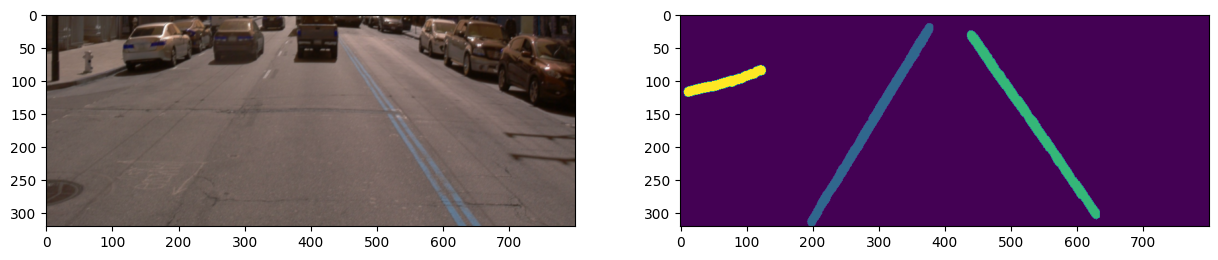

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# img: 3, 320, 800
img_show = img.permute(1, 2, 0).numpy()
ax[0].imshow(img_show)

ax[1].imshow(seg)

In [25]:
np.unique(seg)

array([0, 1, 2, 3], dtype=uint8)

In [26]:
def _parse_lane(lane_line, return_all=False):
    # lane_line: [78]
    has_lane = lane_line[1]
    if has_lane == 0:
        return None

    y_start = lane_line[2]
    x_start = lane_line[3]
    theta = lane_line[4]
    len_inside_img = lane_line[5]
    len_all = np.sum((lane_line[6:] > -1e5))
    len_outside_img = len_all - len_inside_img

    len_inside_img = int(len_inside_img)
    len_outside_img = int(len_outside_img)
    len_all = int(len_all)

    print(
        f"len_all: {len_all}, len_outside_img: {len_outside_img}, len_inside_img: {len_inside_img}"
    )

    n_strips = cfg.num_points - 1
    strip_size = img_h / n_strips
    y_sample = np.arange(cfg.img_h, -1, -strip_size)
    ys = y_sample[len_outside_img : len_outside_img + len_inside_img]
    xs = lane_line[6 + len_outside_img : 6 + len_outside_img + len_inside_img]

    if not return_all:
        return xs, ys
    else:
        ys_all = y_sample[:len_all]
        xs_all = lane_line[6 : 6 + len_all]

        return xs_all, ys_all


def parse_lanes(lane_lines, return_all=False):
    # lane_lines: [N, 78]
    lanes = []
    for lane_line in lane_lines:

        ret = _parse_lane(lane_line, return_all=return_all)
        if ret is not None:
            xs, ys = ret
            lanes.append((xs, ys))
        else:
            continue

    return lanes

len_all: 67, len_outside_img: 0, len_inside_img: 67
len_all: 64, len_outside_img: 0, len_inside_img: 64
len_all: 53, len_outside_img: 45, len_inside_img: 8
len_all: 67, len_outside_img: 0, len_inside_img: 67
len_all: 64, len_outside_img: 0, len_inside_img: 64
len_all: 53, len_outside_img: 45, len_inside_img: 8


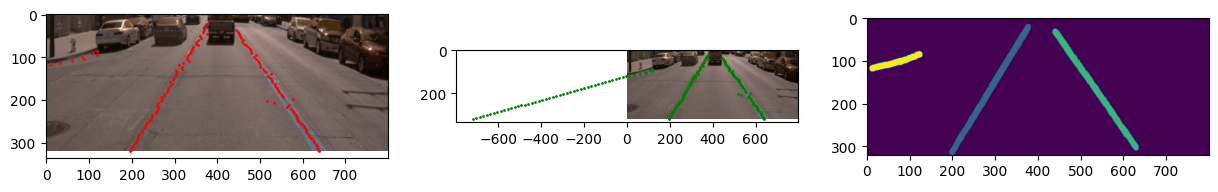

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# img: 3, 320, 800
img_show = img.permute(1, 2, 0).numpy()
ax[0].imshow(img_show)
lanes = parse_lanes(lane_line, return_all=False)
for xs, ys in lanes:
    ax[0].plot(xs, ys, "ro", markersize=1)

ax[1].imshow(img_show)
lanes = parse_lanes(lane_line, return_all=True)
for xs, ys in lanes:
    ax[1].plot(xs, ys, "go", markersize=1)

ax[2].imshow(seg)